In [1]:
import copy
import peft
import torch
from torch import nn
import torch.nn.functional as F
from torchview import draw_graph

In [2]:
import graphviz
graphviz.set_jupyter_format('png')
from torchview import draw_graph

In [3]:
class MLP(nn.Module):
    def __init__(self, num_units_hidden=2000):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Linear(20, num_units_hidden),
            nn.ReLU(),
            nn.Linear(num_units_hidden, num_units_hidden),
            nn.ReLU(),
            nn.Linear(num_units_hidden, 2),
            nn.LogSoftmax(dim=-1),
        )

    def forward(self, X):
        return self.seq(X)

In [5]:
device = 'cpu' if not torch.cuda.is_available() else 'cuda'

In [11]:
X = torch.rand((100, 20)).to(device)
y = (X.sum(1) > 10).long().to(device)

In [18]:
config = peft.LoraConfig(
    r=8,
    target_modules=["seq.0", "seq.2"],
    modules_to_save=["seq.4"],
    init_lora_weights=False
)

In [19]:
module = MLP().to(device)
orig_module = copy.deepcopy(module)
peft_model = peft.get_peft_model(module, config)
criterion = nn.CrossEntropyLoss()

In [20]:
def step(model,X,y):
    outputs = model(X)
    loss = criterion(outputs, y)
    return loss

In [21]:
print(step(module,X,y))

tensor(0.6810, device='cuda:0', grad_fn=<NllLossBackward0>)


In [22]:
print(step(peft_model,X,y))

tensor(0.6810, device='cuda:0', grad_fn=<NllLossBackward0>)


In [23]:
print(step(orig_module,X,y))

tensor(0.6750, device='cuda:0', grad_fn=<NllLossBackward0>)


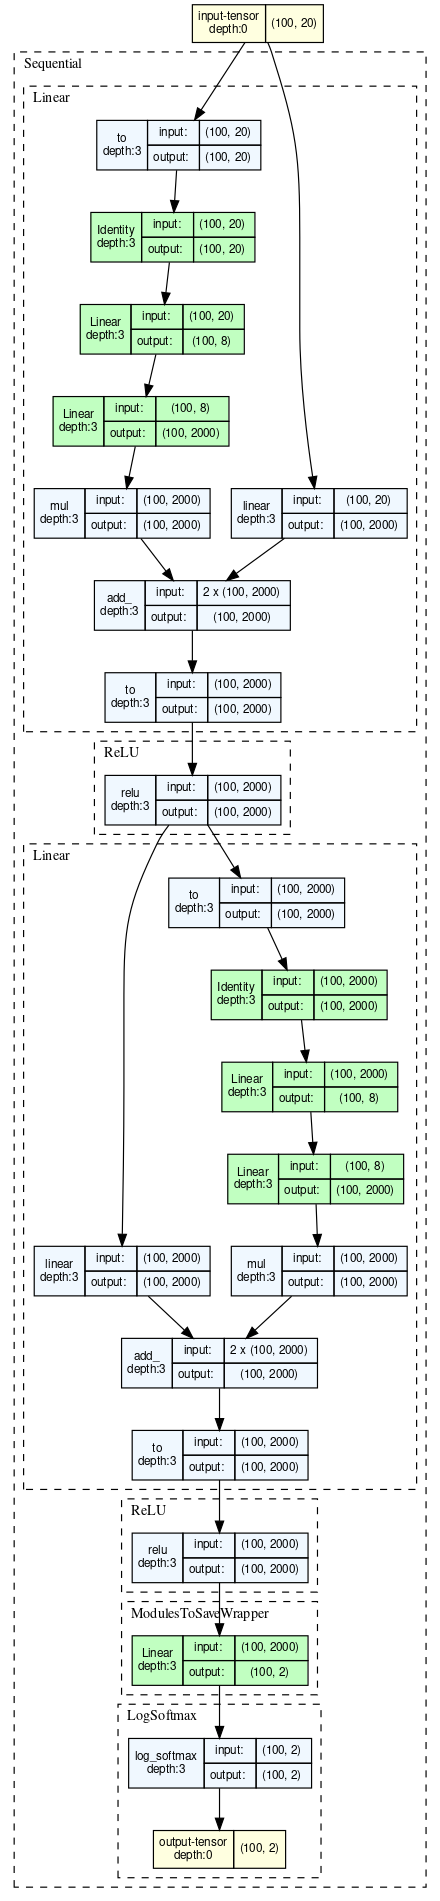

In [16]:
draw_graph(module, input_data=X, 
           device='meta',
           expand_nested=True,
           hide_module_functions=False,).visual_graph

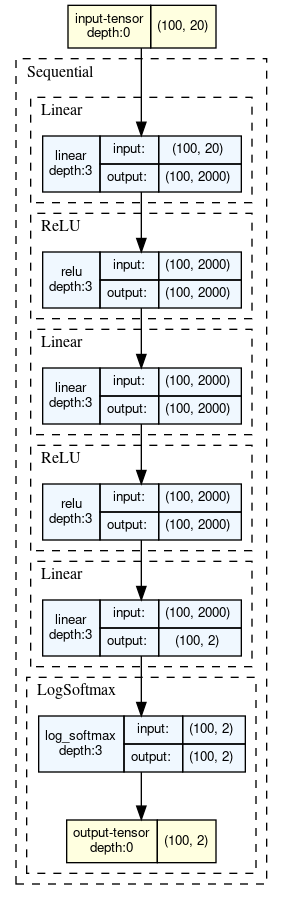

In [17]:
draw_graph(orig_module, input_data=X, 
           device='meta',
           expand_nested=True,
           hide_module_functions=False,).visual_graph